# (6) Assessment of the pipeline
---
Michaël Pierrelée, Aix Marseille Univ, CNRS, IBDM, UMR7288, FRANCE - michael.pierrelee@univ-amu.fr

*Apache License 2.0*

---

Statistics from Bowtie2 alignment of reads against Trinity assembly and from MultiQC are aggregated here to be written in the paper.

Moreover, we wanted to determine the proportion of final DEGs (DEGs used in pathway analysis) with a GO annotation. To do so, we performed Blast and GO annotation using Blast2GO, then we could extract the DEGs with a GO annotation as well as the number of GO terms per gene. We could also compare Blast results from the "1st pipeline" (differential expression analysis -> annotation) and the "2nd pipeline" (Blast2GO).


## Input

* `data/bowtie2_align_stats/`: results of Bowtie2 aligment of reads against Trinity assembly.
* `data/multiqc_stats.tsv`: FastQC statistics aggregated by MultiQC.
* `data/dea_results/synthesis_deg_results.csv`: synthesis of DEA results with the mean of normalized counts, the LFCs and adjusted p-values of comparisons M vs. F at E and S and the interaction term values (LFC, padj and strength of variation in % and categorized into no significant, low, medium or strong variation).
* `svcd-mean_norm_counts.csv`: normalized counts and their means in each condition, from SVCD workflow.
* `data/temp/blasted_trinity_transcripts.pkl`: Transcripts with a Blast hit.
* `data/temp/kegg_ko_file.pkl`: Final KOs used for the pathway analysis and enrichment.
* `data/blast2go/blast2go_go_table.txt`: result tables of Blast2GO Blast and GO annotation.

## Output

* `figures/number_go_per_gene.png`: Number of GO terms per gene (from Blast2GO results).
* `figures/number_go_vs_evalue.png`: Number of GO terms per gene vs. their Blast e-value (from Blast2GO results); genes without both GO terms and Blast hits are not taken into account.
* `figures/species.png`: Distribution of main species annotations by Blast (from Blast2GO results).

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

import glob

In [2]:
sns.set(style='white')

## Statistics of the *de novo* assembly

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

df = pd.DataFrame([{
    'Raw sequence reads':0,
    'Overall alignment rate':0
}])

rate = []
for file in glob.glob('../data/bowtie2_align_stats/*_align*'):
    with open(file, 'r') as f: lines = [line for line in f.readlines()]
    df['Raw sequence reads'] += int( lines[0].split(' reads')[0] )
    rate.append(float( lines[-1].split('%')[0] ))

df['Overall alignment rate'] = np.mean(rate)
df.T

,0
Raw sequence reads,"144,896,003.00"
Overall alignment rate,97.14


In [4]:
df = pd.read_csv('../data/multiqc_stats.tsv', sep='\t')
df['% Dups'] = df['% Dups'].str.replace('%','').astype(float)
df['% GC'] = df['% GC'].str.replace('%','').astype(int)
df['Length'] = df['Length'].str.replace(' bp','').astype(int)
df['% Failed'] = df['% Failed'].str.replace('%','').astype(int)
df['M Seqs'] = df['M Seqs'].astype(float)
pd.DataFrame(df.mean())

,0
% Dups,49.30
% GC,63.25
Length,101.00
% Failed,16.88
M Seqs,12.07


## Assessment of final results using GO annotation of supertranscripts

* The "first" pipeline: the one with late aggregations of transcripts
* The "second" pipeline: the second with early aggregation using SuperTranscript, then Blast and GO annotation by Blast2GO

### Number of DEGs among GO-annotated genes 

In [5]:
dea_results = pd.read_csv( '../data/dea_results/synthesis_deg_results.csv', index_col=0 )
mean_counts = pd.read_csv( '../data/dea_results/svcd-mean_norm_counts.csv', index_col=0 )
blasted_transcripts = pd.read_pickle( '../data/temp/blasted_trinity_transcripts.pkl' )
ko_file = pd.read_pickle( '../data/temp/kegg_ko_file.pkl' )

b2g = pd.read_csv('../data/blast2go/blast2go_go_table.txt', sep='\t')
b2g = b2g[ b2g['SeqName'].isin(mean_counts.index) ]

# more stringent padj
padj_thresh = 1e-4
stringent_degs = dea_results[ (dea_results['padj E'] <= padj_thresh) | (dea_results['padj S'] <= padj_thresh) ]

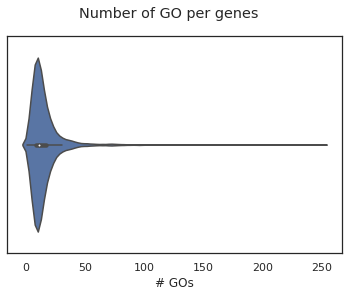

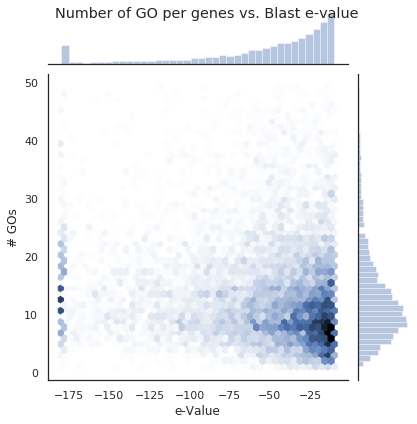

In [6]:
# count the number of GO annotations per sequence
mapped = b2g[ b2g['Tags'] == '[BLASTED, MAPPED]' ]
mapped = mapped.set_index('SeqName')[['e-Value', 'GO IDs']]
mapped['# GOs'] = mapped['GO IDs'].str.split('; ').apply(lambda x: len(x))

# format e-values into log10 base
m = mapped['e-Value'][ mapped['e-Value'] != 0 ].min()
mapped['e-Value'] = mapped['e-Value'].replace( 0, m ).apply( np.log10 )

# distribution of GOs
sns.violinplot(mapped['# GOs'])
plt.suptitle("Number of GO per genes")
plt.savefig('../figures/number_go_per_gene.png', dpi=300, bbox_inches='tight')
plt.show()

# number of GOs vs blast e-value
g = sns.jointplot(data=mapped[mapped['# GOs'] < 50], x='e-Value', y='# GOs', kind='hexbin')
plt.suptitle("Number of GO per genes vs. Blast e-value", y=0.98)
plt.savefig('../figures/number_go_vs_evalue.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
blasted = b2g[ b2g['Tags'].isin(['[BLASTED, MAPPED]', '[BLASTED]']) ]

print('number of genes with counts:', len(mean_counts))
print( 'number of genes with no blast:', len(b2g[ b2g['Tags'] == '[NO-BLAST]' ]) )
print( 'number of genes with blast and GO:', len(b2g[ b2g['Tags'] == '[BLASTED, MAPPED]' ]) )
print( 'number of genes with blast but no GO:', len(b2g[ b2g['Tags'] == '[BLASTED]' ]) )
print( 'number of unique Blast hits:', len(blasted['Description'].unique()) )

print( '\nnumber of DEGs:',
      len(dea_results) )
print( 'overlap between blasted genes in the 2nd pipeline and DEGs:',
      len(set(blasted['SeqName']) & set(dea_results.index)) )
print( 'overlap between blasted genes in the 1st pipeline and DEGs:',
      len(set(blasted_transcripts['#gene_id'])) )
inter = len(set(blasted['SeqName']) & set(blasted_transcripts['#gene_id']))
print( 'overlap between the former and the blasted DEGs in the 1st pipeline:',
       inter )
print( '\t>Jaccard index:', 100*inter / ( len(set(blasted['SeqName']) & set(dea_results.index)) + len(set(blasted_transcripts['#gene_id'])) - inter ) )

mapped_stringent_degs = set(mapped.index) & set(stringent_degs.index)

print( '\nnumber of mapped DEGs with stringent padj:', len(mapped_stringent_degs) )
print( 'number of DEGs with a gene-to-KO and KO-to-gene assignation in the 1st pipeline:',
      len(ko_file['Gene ID']) )

print( 'overlap between mapped DEGs with stringent padj from 2nd pipeline and the latter:',
      len(mapped_stringent_degs & set(ko_file['Gene ID'])) )

number of genes with counts: 52770
number of genes with no blast: 42775
number of genes with blast and GO: 9895
number of genes with blast but no GO: 100
number of unique Blast hits: 7920

number of DEGs: 9117
overlap between blasted genes in the 2nd pipeline and DEGs: 3686
overlap between blasted genes in the 1st pipeline and DEGs: 3767
overlap between the former and the blasted DEGs in the 1st pipeline: 3426
	>Jaccard index: 85.0757387633474

number of mapped DEGs with stringent padj: 2449
number of DEGs with a gene-to-KO and KO-to-gene assignation in the 1st pipeline: 2149
overlap between mapped DEGs with stringent padj from 2nd pipeline and the latter: 1696


### Species from Blast2GO annotation

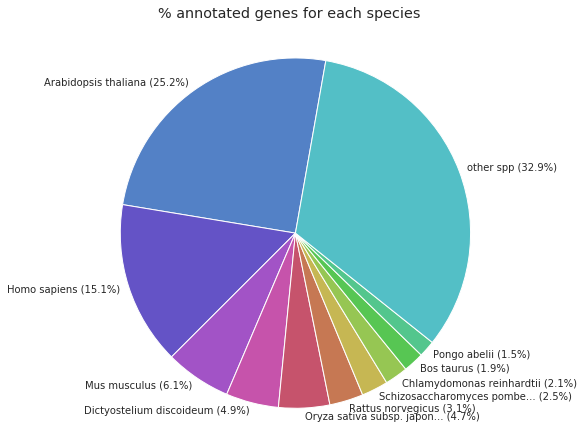

In [8]:
species = blasted['Description'].str.extract("(?<=OS=)(.*)(?= OX=)")[0]
spp = species.value_counts()

others = spp[spp < 128].sum()
spp = spp[spp >= 128]
spp["other spp"] = others

p = round(100 * spp / spp.sum(), 1)
labels = [ f'{s} ({p[s]}%)' if len(s) <= 25 else f'{s[:25].strip()}... ({p[s]}%)' for i, s in enumerate(spp.index)]

fig, ax = plt.subplots(figsize=(7, 7))
fig.suptitle("% annotated genes for each species", x=.5, y=.95)

colors = sns.hls_palette(11, h=.6, l=.55, s=.5)
spp.plot.pie(labels=labels, colors=colors, ax=ax,
             fontsize=10, labeldistance=1.05, startangle=80)
ax.set_ylabel("")
ax.axis('equal')

plt.savefig('../figures/species.png', format='png', bbox_inches='tight')
plt.show()